In [57]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import folium
from math import radians, degrees
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

from sklearn.preprocessing import scale
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import haversine_distances

# 1. Reading the data

## 1.1. Number of schools per barangay

In [2]:
data_dir = '../Data/Education'
education = pd.read_csv(os.path.join(data_dir, 'Education_ForModelling.csv'), index_col=0)
education.shape

(2660, 82)

In [3]:
#Function to display at most 1000 rows and at most 1000 columns
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [4]:
# Change df to geodataframe
education['geometry'] = education['geometry'].apply(wkt.loads)
education = gpd.GeoDataFrame(education, geometry='geometry')

In [5]:
display_all(education.head())

SCH_ID        SCH_NAME    PSGC_PROV    PSGC_MUNI    PSGC_BRGY       LAT  \
0  133049  Abong-Abong ES  PH150700000  PH150704000  PH150704001  6.507703   
1  215015        Akbar ES  PH150700000  PH150708000  PH150708008  6.664125   
2  133154       Amaloy ES  PH150700000  PH150711000  PH150711001  6.443614   
3  133023  Atong-Atong ES  PH150700000  PH150703000  PH150703001  6.660000   
4  133081        Babag ES  PH150700000  PH150713000  PH150713001  6.342007   

         LONG address_type                   geometry  SCH_CAT_CES  \
0  121.910937        given  POINT (121.91094 6.50770)            0   
1  122.195725        given  POINT (122.19572 6.66413)            0   
2  122.126717        given  POINT (122.12672 6.44361)            0   
3  121.899633        given  POINT (121.89963 6.66000)            0   
4  121.954045        given  POINT (121.95404 6.34201)            0   

   SCH_CAT_ES  SCH_CAT_JHS  SCH_CAT_MD  SCH_CAT_PES  SCH_CAT_PJHS  SCH_CAT_PS  \
0           1            0           0            0             0           0   
1           1            0           0            0             0           0   
2           1            0           0            0             0           0   
3           1            0           0            0             0           0   
4           1            0           0            0             0           0   

   SCH_CAT_PSHS  SCH_CAT_SHS  SCH_CAT_SUC  CES_SCH_PROV  ES_SCH_PROV  \
0             0            0            0          16.0        171.0   
1             0            0            0          16.0        171.0   
2             0            0            0          16.0        171.0   
3             0            0            0          16.0        171.0   
4             0            0            0          16.0        171.0   

   JHS_SCH_PROV  MD_SCH_PROV  PES_SCH_PROV  PJHS_SCH_PROV  PS_SCH_PROV  \
0          16.0          1.0           6.0            0.0         14.0   
1          16.0          1.0           6.0            0.0         14.0   
2          16.0          1.0           6.0            0.0         14.0   
3          16.0          1.0           6.0            0.0         14.0   
4          16.0          1.0           6.0            0.0         14.0   

   PSHS_SCH_PROV  SHS_SCH_PROV  SUC_SCH_PROV  CES_SCH_MUNI  ES_SCH_MUNI  \
0            6.0          10.0           1.0           2.0         16.0   
1            6.0          10.0           1.0           0.0          5.0   
2            6.0          10.0           1.0           0.0         13.0   
3            6.0          10.0           1.0           1.0         18.0   
4            6.0          10.0           1.0           1.0         11.0   

   JHS_SCH_MUNI  MD_SCH_MUNI  PES_SCH_MUNI  PJHS_SCH_MUNI  PS_SCH_MUNI  \
0           0.0          0.0           0.0            0.0          0.0   
1           1.0          0.0           0.0            0.0          1.0   
2           0.0          0.0           0.0            0.0          0.0   
3           2.0          0.0           0.0            0.0          2.0   
4           2.0          0.0           0.0            0.0          2.0   

   PSHS_SCH_MUNI  SHS_SCH_MUNI  SUC_SCH_MUNI  CES_SCH_BRGY  ES_SCH_BRGY  \
0            1.0           1.0           0.0           0.0          2.0   
1            0.0           0.0           0.0           0.0          1.0   
2            0.0           0.0           0.0           0.0          1.0   
3            0.0           1.0           0.0           0.0          1.0   
4            0.0           0.0           0.0           0.0          1.0   

   JHS_SCH_BRGY  MD_SCH_BRGY  PES_SCH_BRGY  PJHS_SCH_BRGY  PS_SCH_BRGY  \
0           0.0          0.0           0.0            0.0          0.0   
1           1.0          0.0           0.0            0.0          0.0   
2           0.0          0.0           0.0            0.0          0.0   
3           1.0          0.0           0.0            0.0          0.0   
4           0.0          0.0   

In [6]:
education.describe()

SCH_ID          LAT         LONG  SCH_CAT_CES   SCH_CAT_ES  \
count    2660.000000  2660.000000  2660.000000  2660.000000  2660.000000   
mean   199274.220677     6.885773   122.835085     0.066165     0.481955   
std    109672.983887     1.089614     5.708151     0.248618     0.499768   
min    100804.000000     0.000000   -96.683250     0.000000     0.000000   
25%    133733.750000     6.053499   121.135925     0.000000     0.000000   
50%    134477.500000     7.011516   124.158333     0.000000     0.000000   
75%    217062.250000     7.785911   124.325811     0.000000     1.000000   
max    800161.000000    33.034414   124.958000     1.000000     1.000000   

       SCH_CAT_JHS   SCH_CAT_MD  SCH_CAT_PES  SCH_CAT_PJHS   SCH_CAT_PS  ...  \
count  2660.000000  2660.000000  2660.000000   2660.000000  2660.000000  ...   
mean      0.059023     0.014662     0.039850      0.021805     0.242105  ...   
std       0.235711     0.120217     0.195643      0.146072     0.428438  ...   
min       0.000000     0.000000     0.000000      0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000      0.000000     0.000000  ...   
50%       0.000000     0.000000     0.000000      0.000000     0.000000  ...   
75%       0.000000     0.000000     0.000000      0.000000     0.000000  ...   
max       1.000000     1.000000     1.000000      1.000000     1.000000  ...   

       Female_under10  Female_10to20  Female_21to30  Female_31to60  \
count     2363.000000    2363.000000    2363.000000    2363.000000   
mean       387.896318     385.636056     240.171815     372.898434   
std        534.492732     588.247020     352.305785     522.785604   
min         19.000000       7.000000      10.000000      28.000000   
25%        138.000000     129.000000      80.000000     123.000000   
50%        240.000000     213.000000     136.000000     213.000000   
75%        429.000000     381.000000     246.000000     379.500000   
max       5068.000000    5688.000000    3286.000000    4652.000000   

       Female_over60  Male_under10  Male_10to20  Male_21to30  Male_31to60  \
count    2363.000000   2363.000000  2363.000000  2363.000000  2363.000000   
mean       44.444350    396.347017   383.295387   222.926788   373.874312   
std        67.482978    544.514111   583.895162   331.203827   518.722139   
min         0.000000     10.000000    13.000000     9.000000    27.000000   
25%        10.000000    139.000000   128.000000    72.000000   125.000000   
50%        22.000000    238.000000   212.000000   123.000000   217.000000   
75%        48.000000    442.000000   389.500000   230.500000   377.000000   
max       522.000000   5203.000000  5573.000000  3239.000000  4726.000000   

       Male_over60  
count  2363.000000  
mean     47.710961  
std      70.474669  
min       0.000000  
25%      12.000000  
50%      24.000000  
75%      53.000000  
max     568.000000  

[8 rows x 76 columns]

In [7]:
# Keep only one record for each brgy and needed features only
brgy_info = education[['PSGC_BRGY',
        'PSGC_MUNI',
        'PSGC_PROV',
        'CES_SCH_BRGY',
        'ES_SCH_BRGY',
        'JHS_SCH_BRGY',
        'MD_SCH_BRGY',
        'PES_SCH_BRGY',
        'PJHS_SCH_BRGY',
        'PS_SCH_BRGY',
        'PSHS_SCH_BRGY',
        'SHS_SCH_BRGY',
        'SUC_SCH_BRGY',
        'BRGY_SCHOOLS']].drop_duplicates(subset='PSGC_BRGY', keep='first')

brgy_info.head()

PSGC_BRGY    PSGC_MUNI    PSGC_PROV  CES_SCH_BRGY  ES_SCH_BRGY  \
0  PH150704001  PH150704000  PH150700000           0.0          2.0   
1  PH150708008  PH150708000  PH150700000           0.0          1.0   
2  PH150711001  PH150711000  PH150700000           0.0          1.0   
3  PH150703001  PH150703000  PH150700000           0.0          1.0   
4  PH150713001  PH150713000  PH150700000           0.0          1.0   

   JHS_SCH_BRGY  MD_SCH_BRGY  PES_SCH_BRGY  PJHS_SCH_BRGY  PS_SCH_BRGY  \
0           0.0          0.0           0.0            0.0          0.0   
1           1.0          0.0           0.0            0.0          0.0   
2           0.0          0.0           0.0            0.0          0.0   
3           1.0          0.0           0.0            0.0          0.0   
4           0.0          0.0           0.0            0.0          0.0   

   PSHS_SCH_BRGY  SHS_SCH_BRGY  SUC_SCH_BRGY  BRGY_SCHOOLS  
0            0.0           0.0           0.0             2  
1            0.0           0.0           0.0             2  
2            0.0           0.0           0.0             1  
3            0.0           0.0           0.0             2  
4            0.0           0.0           0.0             1

In [8]:
# Combine similar features, 
# i.e., elementary (central ES, ES, primary ES, primary), JHS (JHS, primary JHS), SHS (SHS, primary SHS) schools
brgy_info['num_ES'] = brgy_info['CES_SCH_BRGY'] + brgy_info['ES_SCH_BRGY'] + brgy_info['PES_SCH_BRGY'] + brgy_info['PS_SCH_BRGY']
brgy_info['num_JHS'] = brgy_info['JHS_SCH_BRGY'] + brgy_info['PJHS_SCH_BRGY']
brgy_info['num_SHS'] = brgy_info['PSHS_SCH_BRGY'] + brgy_info['SHS_SCH_BRGY']

# Drop original columns
brgy_info.drop(columns=['CES_SCH_BRGY', 'ES_SCH_BRGY', 'PES_SCH_BRGY', 'PS_SCH_BRGY',
                       'JHS_SCH_BRGY', 'PJHS_SCH_BRGY',
                       'PSHS_SCH_BRGY', 'SHS_SCH_BRGY'],
              inplace=True)

In [9]:
# Rename columns
brgy_info.rename(columns={'Bgy_Code': 'PSGC_BRGY', 'SUC_SCH_BRGY': 'num_SUC', 'MD_SCH_BRGY': 'num_MD'}, inplace=True)
brgy_info.head()

PSGC_BRGY    PSGC_MUNI    PSGC_PROV  num_MD  num_SUC  BRGY_SCHOOLS  \
0  PH150704001  PH150704000  PH150700000     0.0      0.0             2   
1  PH150708008  PH150708000  PH150700000     0.0      0.0             2   
2  PH150711001  PH150711000  PH150700000     0.0      0.0             1   
3  PH150703001  PH150703000  PH150700000     0.0      0.0             2   
4  PH150713001  PH150713000  PH150700000     0.0      0.0             1   

   num_ES  num_JHS  num_SHS  
0     2.0      0.0      0.0  
1     1.0      1.0      0.0  
2     1.0      0.0      0.0  
3     1.0      1.0      0.0  
4     1.0      0.0      0.0

## 1.2 Administrative boundaries of barangays

<AxesSubplot:>

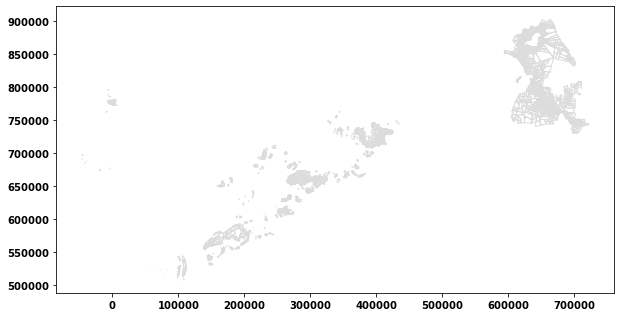

In [10]:
# Read barangay-level admin boundaries from shp file
brgy_dir = '../Data/Reference/Administrative Boundaries - BARMM Barangays ao 20190206 (PSA 2016)'
brgy_file = 'AdministrativeBoundariesBARMMBarangays20190206PSA2016.shp'
brgy_bounds = gpd.read_file(os.path.join(brgy_dir, brgy_file))

# Visualize bounds
brgy_bounds['geometry'].plot(figsize=(10,10), color='none', edgecolor='gainsboro', zorder=3)

In [11]:
# Add the centroid of each city / municipality
brgy_bounds['centroid'] = brgy_bounds['geometry'].centroid

# Change coordinate reference system to 4326 (lat/long)
brgy_bounds['geometry'] = brgy_bounds['geometry'].to_crs(epsg=4326)
brgy_bounds['centroid'] = brgy_bounds['centroid'].to_crs(epsg=4326)

brgy_bounds['longitude'] = brgy_bounds['centroid'].x
brgy_bounds['latitude'] = brgy_bounds['centroid'].y

display_all(brgy_bounds.head())

Reg_Code                                     Reg_Name     Pro_Code  \
0  PH150000000  AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM)  PH157000000   
1  PH150000000  AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM)  PH157000000   
2  PH150000000  AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM)  PH157000000   
3  PH150000000  AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM)  PH157000000   
4  PH150000000  AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM)  PH157000000   

    Pro_Name     Mun_Code                     Mun_Name     Bgy_Code  \
0  TAWI-TAWI  PH157001000  PANGLIMA SUGALA (BALIMBING)  PH157001001   
1  TAWI-TAWI  PH157001000  PANGLIMA SUGALA (BALIMBING)  PH157001002   
2  TAWI-TAWI  PH157001000  PANGLIMA SUGALA (BALIMBING)  PH157001003   
3  TAWI-TAWI  PH157001000  PANGLIMA SUGALA (BALIMBING)  PH157001004   
4  TAWI-TAWI  PH157001000  PANGLIMA SUGALA (BALIMBING)  PH157001005   

           Bgy_Name                                           geometry  \
0  Balimbing Proper  MULTIPOLYGON (((119.95374 5.07851, 119.95384 5...   
1  Batu-batu (Pob.)  POLYGON ((119.88709 5.06919, 119.88709 5.06920...   
2              Buan  MULTIPOLYGON (((120.06363 5.16131, 120.06365 5...   
3            Dungon  POLYGON ((120.13585 5.19601, 120.13584 5.19603...   
4       Luuk Buntal  MULTIPOLYGON (((119.98776 4.98564, 119.98774 4...   

                    centroid   longitude  latitude  
0  POINT (119.96552 5.09753)  119.965518  5.097532  
1  POINT (119.88302 5.09129)  119.883020  5.091289  
2  POINT (120.00070 5.15760)  120.000703  5.157595  
3  POINT (120.12350 5.21772)  120.123501  5.217723  
4  POINT (120.00454 4.98161)  120.004538  4.981608

In [12]:
# Rename columns
brgy_bounds.rename(columns={'Bgy_Code': 'PSGC_BRGY'}, inplace=True)

# Keep only desired features
brgy_coords = brgy_bounds[['PSGC_BRGY', 'geometry', 'centroid', 'longitude', 'latitude']]
brgy_coords.head()

PSGC_BRGY                                           geometry  \
0  PH157001001  MULTIPOLYGON (((119.95374 5.07851, 119.95384 5...   
1  PH157001002  POLYGON ((119.88709 5.06919, 119.88709 5.06920...   
2  PH157001003  MULTIPOLYGON (((120.06363 5.16131, 120.06365 5...   
3  PH157001004  POLYGON ((120.13585 5.19601, 120.13584 5.19603...   
4  PH157001005  MULTIPOLYGON (((119.98776 4.98564, 119.98774 4...   

                    centroid   longitude  latitude  
0  POINT (119.96552 5.09753)  119.965518  5.097532  
1  POINT (119.88302 5.09129)  119.883020  5.091289  
2  POINT (120.00070 5.15760)  120.000703  5.157595  
3  POINT (120.12350 5.21772)  120.123501  5.217723  
4  POINT (120.00454 4.98161)  120.004538  4.981608

## 1.3 Population per barangay

In [13]:
# Read barangay-level population
pop_dir = '../Data/Reference'
pop_file = 'Population 2010, 2015 ARMM,BCT.csv'
pop = pd.read_csv(os.path.join(pop_dir, pop_file))
pop.head()

REGI    PSGC_REGI     PROV    PSGC_PROV  \
0  Autonomous Region In Muslim Mindanao  PH150000000  Basilan  PH150700000   
1  Autonomous Region In Muslim Mindanao  PH150000000  Basilan  PH150700000   
2  Autonomous Region In Muslim Mindanao  PH150000000  Basilan  PH150700000   
3  Autonomous Region In Muslim Mindanao  PH150000000  Basilan  PH150700000   
4  Autonomous Region In Muslim Mindanao  PH150000000  Basilan  PH150700000   

        MuniCities PSGC_CITY/MUNI    BrgyName    PSGC_BRGY  BCT  Pop2010  ...  \
0  City Of Lamitan    PH150702000        Arco  PH150702001    1      800  ...   
1  City Of Lamitan    PH150702000       Ba-as  PH150702002    1     1266  ...   
2  City Of Lamitan    PH150702000    Baimbing  PH150702004    1      451  ...   
3  City Of Lamitan    PH150702000  Balagtasan  PH150702005    1     2597  ...   
4  City Of Lamitan    PH150702000       Balas  PH150702006    1     2809  ...   

   80_abv_mal  num_hh0_fem.1  bel_20_hh0_fem  20-29_hh0_fem  30-39_hh0_fem  \
0         3.0           23.0             0.0            1.0            3.0   
1         3.0           72.0             0.0            9.0           13.0   
2         0.0           25.0             0.0            4.0            1.0   
3         6.0           76.0             1.0            2.0           10.0   
4         2.0          166.0             2.0           26.0           39.0   

   40-49_hh0_fem  50-59_hh0_fem  60-69_hh0_fem  70-79_hh0_fem  80_abv_fem  
0            0.0            8.0            6.0            2.0         3.0  
1           16.0           13.0           14.0            7.0         0.0  
2            3.0            4.0            8.0            4.0         1.0  
3           18.0           24.0            7.0           13.0         1.0  
4           28.0           32.0           28.0            7.0         4.0  

[5 rows x 288 columns]

In [14]:
# Checking % missing values
display_all(pop.isnull().sum()* 100 / len(pop))

REGI                       0.000000
PSGC_REGI                  0.000000
PROV                       0.000000
PSGC_PROV                  0.000000
MuniCities                 0.000000
PSGC_CITY/MUNI             0.000000
BrgyName                   0.000000
PSGC_BRGY                  0.000000
BCT                        0.000000
Pop2010                    0.000000
Pop2015                    0.000000
HH_pop                     8.783535
num_hh0                    8.783535
num_hh0_mal                8.783535
num_hh0_fem                8.783535
Tot_sin_age_bot            8.783535
sin_age_bot_und_001        8.783535
sin_age_bot_001            8.783535
sin_age_bot_002            8.783535
sin_age_bot_003            8.783535
sin_age_bot_004            8.783535
sin_age_bot_005            8.783535
sin_age_bot_006            8.783535
sin_age_bot_007            8.783535
sin_age_bot_008            8.783535
sin_age_bot_009            8.783535
sin_age_bot_010            8.783535
sin_age_bot_011            8

In [15]:
# Fill missing values with mean for simplicity
pop.fillna(value=pop.mean(), inplace=True)

In [16]:
"""
# Group population per school level (elem, jhs, shs, suc)
Note: Entry ages based on K to 12 program

Ages 6-11
    'CES_SCH_BRGY': central elementary school
    'ES_SCH_BRGY': elementary school
    'PES_SCH_BRGY': primary elementary school
    'PS_SCH_BRGY': primary school
    
Ages 12-15
    'JHS_SCH_BRGY': junior high school    
    'PJHS_SCH_BRGY': primary junior high school

Ages 16-17
    'PSHS_SCH_BRGY': primary senior high school
    'SHS_SCH_BRGY': senior high school

Ages 18-22
    'SUC_SCH_BRGY': state university/college
"""

pop['elem_age_pop'] = pop.loc[:, 'sin_age_bot_006':'sin_age_bot_011'].sum(axis=1)
pop['jhs_age_pop'] = pop.loc[:, 'sin_age_bot_012':'sin_age_bot_015'].sum(axis=1)
pop['shs_age_pop'] = pop.loc[:, 'sin_age_bot_016':'sin_age_bot_017'].sum(axis=1)
pop['suc_age_pop'] = pop.loc[:, 'sin_age_bot_018':'sin_age_bot_022'].sum(axis=1)

In [17]:
# Keep only desired features
pop_school = pop[['PSGC_BRGY', 'elem_age_pop', 'jhs_age_pop', 'shs_age_pop', 'suc_age_pop']]

In [18]:
pop_school.head()

PSGC_BRGY  elem_age_pop  jhs_age_pop  shs_age_pop  suc_age_pop
0  PH150702001          95.0         49.0         17.0         68.0
1  PH150702002         180.0        102.0         60.0        139.0
2  PH150702004          81.0         61.0         27.0         50.0
3  PH150702005         366.0        192.0         98.0        251.0
4  PH150702006         442.0        303.0        145.0        283.0

## 1.4 School locations

In [19]:
school_feat = ['SCH_NAME', 'PSGC_MUNI', 'PSGC_BRGY', 'LAT', 'LONG', 'geometry', 'SCH_CAT_CES', 'SCH_CAT_ES', 'SCH_CAT_JHS', 'SCH_CAT_MD', 'SCH_CAT_PES', 'SCH_CAT_PJHS', 'SCH_CAT_PS', 'SCH_CAT_PSHS', 'SCH_CAT_SHS', 'SCH_CAT_SUC']
schools = education[school_feat]
schools.head()

SCH_NAME    PSGC_MUNI    PSGC_BRGY       LAT        LONG  \
0  Abong-Abong ES  PH150704000  PH150704001  6.507703  121.910937   
1        Akbar ES  PH150708000  PH150708008  6.664125  122.195725   
2       Amaloy ES  PH150711000  PH150711001  6.443614  122.126717   
3  Atong-Atong ES  PH150703000  PH150703001  6.660000  121.899633   
4        Babag ES  PH150713000  PH150713001  6.342007  121.954045   

                    geometry  SCH_CAT_CES  SCH_CAT_ES  SCH_CAT_JHS  \
0  POINT (121.91094 6.50770)            0           1            0   
1  POINT (122.19572 6.66413)            0           1            0   
2  POINT (122.12672 6.44361)            0           1            0   
3  POINT (121.89963 6.66000)            0           1            0   
4  POINT (121.95404 6.34201)            0           1            0   

   SCH_CAT_MD  SCH_CAT_PES  SCH_CAT_PJHS  SCH_CAT_PS  SCH_CAT_PSHS  \
0           0            0             0           0             0   
1           0            0             0           0             0   
2           0            0             0           0             0   
3           0            0             0           0             0   
4           0            0             0           0             0   

   SCH_CAT_SHS  SCH_CAT_SUC  
0            0            0  
1            0            0  
2            0            0  
3            0            0  
4            0            0

In [20]:
# Checking for missing values
schools.isnull().sum()

SCH_NAME        0
PSGC_MUNI       0
PSGC_BRGY       0
LAT             0
LONG            0
geometry        0
SCH_CAT_CES     0
SCH_CAT_ES      0
SCH_CAT_JHS     0
SCH_CAT_MD      0
SCH_CAT_PES     0
SCH_CAT_PJHS    0
SCH_CAT_PS      0
SCH_CAT_PSHS    0
SCH_CAT_SHS     0
SCH_CAT_SUC     0
dtype: int64

In [21]:
schools.shape

(2660, 16)

## 1.5 Merging into one dataframe

In [22]:
brgy_df = brgy_coords.merge(brgy_info, how='left', on='PSGC_BRGY')
brgy_df.head()

PSGC_BRGY                                           geometry  \
0  PH157001001  MULTIPOLYGON (((119.95374 5.07851, 119.95384 5...   
1  PH157001002  POLYGON ((119.88709 5.06919, 119.88709 5.06920...   
2  PH157001003  MULTIPOLYGON (((120.06363 5.16131, 120.06365 5...   
3  PH157001004  POLYGON ((120.13585 5.19601, 120.13584 5.19603...   
4  PH157001005  MULTIPOLYGON (((119.98776 4.98564, 119.98774 4...   

                    centroid   longitude  latitude    PSGC_MUNI    PSGC_PROV  \
0  POINT (119.96552 5.09753)  119.965518  5.097532  PH157001000  PH157000000   
1  POINT (119.88302 5.09129)  119.883020  5.091289  PH157001000  PH157000000   
2  POINT (120.00070 5.15760)  120.000703  5.157595  PH157001000  PH157000000   
3  POINT (120.12350 5.21772)  120.123501  5.217723  PH157001000  PH157000000   
4  POINT (120.00454 4.98161)  120.004538  4.981608  PH157001000  PH157000000   

   num_MD  num_SUC  BRGY_SCHOOLS  num_ES  num_JHS  num_SHS  
0     0.0      0.0           3.0     2.0      0.0      1.0  
1     0.0      0.0           2.0     1.0      0.0      1.0  
2     0.0      1.0           6.0     5.0      0.0      0.0  
3     0.0      0.0           1.0     1.0      0.0      0.0  
4     0.0      0.0           2.0     2.0      0.0      0.0

In [23]:
brgy_df = brgy_df.merge(pop_school, how='left', on='PSGC_BRGY')
brgy_df.head()

PSGC_BRGY                                           geometry  \
0  PH157001001  MULTIPOLYGON (((119.95374 5.07851, 119.95384 5...   
1  PH157001002  POLYGON ((119.88709 5.06919, 119.88709 5.06920...   
2  PH157001003  MULTIPOLYGON (((120.06363 5.16131, 120.06365 5...   
3  PH157001004  POLYGON ((120.13585 5.19601, 120.13584 5.19603...   
4  PH157001005  MULTIPOLYGON (((119.98776 4.98564, 119.98774 4...   

                    centroid   longitude  latitude    PSGC_MUNI    PSGC_PROV  \
0  POINT (119.96552 5.09753)  119.965518  5.097532  PH157001000  PH157000000   
1  POINT (119.88302 5.09129)  119.883020  5.091289  PH157001000  PH157000000   
2  POINT (120.00070 5.15760)  120.000703  5.157595  PH157001000  PH157000000   
3  POINT (120.12350 5.21772)  120.123501  5.217723  PH157001000  PH157000000   
4  POINT (120.00454 4.98161)  120.004538  4.981608  PH157001000  PH157000000   

   num_MD  num_SUC  BRGY_SCHOOLS  num_ES  num_JHS  num_SHS  elem_age_pop  \
0     0.0      0.0           3.0     2.0      0.0      1.0         951.0   
1     0.0      0.0           2.0     1.0      0.0      1.0         483.0   
2     0.0      1.0           6.0     5.0      0.0      0.0         717.0   
3     0.0      0.0           1.0     1.0      0.0      0.0         321.0   
4     0.0      0.0           2.0     2.0      0.0      0.0         367.0   

   jhs_age_pop  shs_age_pop  suc_age_pop  
0        543.0        217.0        512.0  
1        310.0        143.0        395.0  
2        433.0        180.0        370.0  
3        166.0         66.0        145.0  
4        190.0         85.0        209.0

In [24]:
# Add ratio columns, i.e., ratio of population to number of schools
# brgy_df['elem_pop_to_num_elem'] = brgy_df['elem_age_pop'] / brgy_df['num_ES']
# brgy_df['jhs_pop_to_num_jhs'] = brgy_df['jhs_age_pop'] / brgy_df['num_JHS']
# brgy_df['shs_pop_to_num_shs'] = brgy_df['shs_age_pop'] / brgy_df['num_SHS']
# brgy_df['suc_pop_to_num_suc'] = brgy_df['suc_age_pop'] / brgy_df['num_SUC']
# There are some brgys with 0 schools, so the above ratios produce inf values

# Get ratio of number of schools to population instead
brgy_df['num_elem_to_elem_age_pop'] = brgy_df['num_ES'] / brgy_df['elem_age_pop']
brgy_df['num_jhs_to_jhs_age_pop'] = brgy_df['num_JHS'] / brgy_df['jhs_age_pop']
brgy_df['num_shs_to_shs_age_pop'] = brgy_df['num_SHS'] / brgy_df['shs_age_pop']
brgy_df['num_suc_to_suc_age_pop'] = brgy_df['num_SUC'] / brgy_df['suc_age_pop'] 

brgy_df.head()

PSGC_BRGY                                           geometry  \
0  PH157001001  MULTIPOLYGON (((119.95374 5.07851, 119.95384 5...   
1  PH157001002  POLYGON ((119.88709 5.06919, 119.88709 5.06920...   
2  PH157001003  MULTIPOLYGON (((120.06363 5.16131, 120.06365 5...   
3  PH157001004  POLYGON ((120.13585 5.19601, 120.13584 5.19603...   
4  PH157001005  MULTIPOLYGON (((119.98776 4.98564, 119.98774 4...   

                    centroid   longitude  latitude    PSGC_MUNI    PSGC_PROV  \
0  POINT (119.96552 5.09753)  119.965518  5.097532  PH157001000  PH157000000   
1  POINT (119.88302 5.09129)  119.883020  5.091289  PH157001000  PH157000000   
2  POINT (120.00070 5.15760)  120.000703  5.157595  PH157001000  PH157000000   
3  POINT (120.12350 5.21772)  120.123501  5.217723  PH157001000  PH157000000   
4  POINT (120.00454 4.98161)  120.004538  4.981608  PH157001000  PH157000000   

   num_MD  num_SUC  BRGY_SCHOOLS  ...  num_JHS  num_SHS  elem_age_pop  \
0     0.0      0.0           3.0  ...      0.0      1.0         951.0   
1     0.0      0.0           2.0  ...      0.0      1.0         483.0   
2     0.0      1.0           6.0  ...      0.0      0.0         717.0   
3     0.0      0.0           1.0  ...      0.0      0.0         321.0   
4     0.0      0.0           2.0  ...      0.0      0.0         367.0   

   jhs_age_pop  shs_age_pop  suc_age_pop  num_elem_to_elem_age_pop  \
0        543.0        217.0        512.0                  0.002103   
1        310.0        143.0        395.0                  0.002070   
2        433.0        180.0        370.0                  0.006974   
3        166.0         66.0        145.0                  0.003115   
4        190.0         85.0        209.0                  0.005450   

   num_jhs_to_jhs_age_pop  num_shs_to_shs_age_pop  num_suc_to_suc_age_pop  
0                     0.0                0.004608                0.000000  
1                     0.0                0.006993                0.000000  
2                     0.0                0.000000                0.002703  
3                     0.0                0.000000                0.000000  
4                     0.0                0.000000                0.000000  

[5 rows x 21 columns]

In [25]:
brgy_df.head()

PSGC_BRGY                                           geometry  \
0  PH157001001  MULTIPOLYGON (((119.95374 5.07851, 119.95384 5...   
1  PH157001002  POLYGON ((119.88709 5.06919, 119.88709 5.06920...   
2  PH157001003  MULTIPOLYGON (((120.06363 5.16131, 120.06365 5...   
3  PH157001004  POLYGON ((120.13585 5.19601, 120.13584 5.19603...   
4  PH157001005  MULTIPOLYGON (((119.98776 4.98564, 119.98774 4...   

                    centroid   longitude  latitude    PSGC_MUNI    PSGC_PROV  \
0  POINT (119.96552 5.09753)  119.965518  5.097532  PH157001000  PH157000000   
1  POINT (119.88302 5.09129)  119.883020  5.091289  PH157001000  PH157000000   
2  POINT (120.00070 5.15760)  120.000703  5.157595  PH157001000  PH157000000   
3  POINT (120.12350 5.21772)  120.123501  5.217723  PH157001000  PH157000000   
4  POINT (120.00454 4.98161)  120.004538  4.981608  PH157001000  PH157000000   

   num_MD  num_SUC  BRGY_SCHOOLS  ...  num_JHS  num_SHS  elem_age_pop  \
0     0.0      0.0           3.0  ...      0.0      1.0         951.0   
1     0.0      0.0           2.0  ...      0.0      1.0         483.0   
2     0.0      1.0           6.0  ...      0.0      0.0         717.0   
3     0.0      0.0           1.0  ...      0.0      0.0         321.0   
4     0.0      0.0           2.0  ...      0.0      0.0         367.0   

   jhs_age_pop  shs_age_pop  suc_age_pop  num_elem_to_elem_age_pop  \
0        543.0        217.0        512.0                  0.002103   
1        310.0        143.0        395.0                  0.002070   
2        433.0        180.0        370.0                  0.006974   
3        166.0         66.0        145.0                  0.003115   
4        190.0         85.0        209.0                  0.005450   

   num_jhs_to_jhs_age_pop  num_shs_to_shs_age_pop  num_suc_to_suc_age_pop  
0                     0.0                0.004608                0.000000  
1                     0.0                0.006993                0.000000  
2                     0.0                0.000000                0.002703  
3                     0.0                0.000000                0.000000  
4                     0.0                0.000000                0.000000  

[5 rows x 21 columns]

## 1.6 Add new features
1. Distances of barangay centroids to nearest schools 

In [26]:
schools.head()

SCH_NAME    PSGC_MUNI    PSGC_BRGY       LAT        LONG  \
0  Abong-Abong ES  PH150704000  PH150704001  6.507703  121.910937   
1        Akbar ES  PH150708000  PH150708008  6.664125  122.195725   
2       Amaloy ES  PH150711000  PH150711001  6.443614  122.126717   
3  Atong-Atong ES  PH150703000  PH150703001  6.660000  121.899633   
4        Babag ES  PH150713000  PH150713001  6.342007  121.954045   

                    geometry  SCH_CAT_CES  SCH_CAT_ES  SCH_CAT_JHS  \
0  POINT (121.91094 6.50770)            0           1            0   
1  POINT (122.19572 6.66413)            0           1            0   
2  POINT (122.12672 6.44361)            0           1            0   
3  POINT (121.89963 6.66000)            0           1            0   
4  POINT (121.95404 6.34201)            0           1            0   

   SCH_CAT_MD  SCH_CAT_PES  SCH_CAT_PJHS  SCH_CAT_PS  SCH_CAT_PSHS  \
0           0            0             0           0             0   
1           0            0             0           0             0   
2           0            0             0           0             0   
3           0            0             0           0             0   
4           0            0             0           0             0   

   SCH_CAT_SHS  SCH_CAT_SUC  
0            0            0  
1            0            0  
2            0            0  
3            0            0  
4            0            0

In [27]:
# Combine same school categories (ES, JHS, SHS, SUC)
es = lambda x: 1 if ((x['SCH_CAT_CES']==1) | (x['SCH_CAT_ES']==1) | (x['SCH_CAT_PES']==1) | (x['SCH_CAT_PS']==1)) else 0
jhs = lambda x: 1 if ((x['SCH_CAT_JHS']==1) | (x['SCH_CAT_PJHS']==1)) else 0
shs = lambda x: 1 if ((x['SCH_CAT_SHS']==1) | (x['SCH_CAT_PSHS']==1)) else 0
suc = lambda x: 1 if x['SCH_CAT_SUC']==1 else 0

schools['cat_ES'] = schools.apply(es, axis=1)
schools['cat_JHS'] = schools.apply(jhs, axis=1)
schools['cat_SHS'] = schools.apply(shs, axis=1)
schools['cat_SUC'] = schools.apply(suc, axis=1)
schools.head()

SCH_NAME    PSGC_MUNI    PSGC_BRGY       LAT        LONG  \
0  Abong-Abong ES  PH150704000  PH150704001  6.507703  121.910937   
1        Akbar ES  PH150708000  PH150708008  6.664125  122.195725   
2       Amaloy ES  PH150711000  PH150711001  6.443614  122.126717   
3  Atong-Atong ES  PH150703000  PH150703001  6.660000  121.899633   
4        Babag ES  PH150713000  PH150713001  6.342007  121.954045   

                    geometry  SCH_CAT_CES  SCH_CAT_ES  SCH_CAT_JHS  \
0  POINT (121.91094 6.50770)            0           1            0   
1  POINT (122.19572 6.66413)            0           1            0   
2  POINT (122.12672 6.44361)            0           1            0   
3  POINT (121.89963 6.66000)            0           1            0   
4  POINT (121.95404 6.34201)            0           1            0   

   SCH_CAT_MD  SCH_CAT_PES  SCH_CAT_PJHS  SCH_CAT_PS  SCH_CAT_PSHS  \
0           0            0             0           0             0   
1           0            0             0           0             0   
2           0            0             0           0             0   
3           0            0             0           0             0   
4           0            0             0           0             0   

   SCH_CAT_SHS  SCH_CAT_SUC  cat_ES  cat_JHS  cat_SHS  cat_SUC  
0            0            0       1        0        0        0  
1            0            0       1        0        0        0  
2            0            0       1        0        0        0  
3            0            0       1        0        0        0  
4            0            0       1        0        0        0

In [28]:
# Drop original category columns
schools.drop(columns=['SCH_CAT_CES', 'SCH_CAT_ES', 'SCH_CAT_PES', 'SCH_CAT_PS', 'SCH_CAT_JHS', 'SCH_CAT_PJHS', 'SCH_CAT_SHS',
                     'SCH_CAT_PSHS', 'SCH_CAT_SUC'], inplace=True)

In [29]:
schools.head()

SCH_NAME    PSGC_MUNI    PSGC_BRGY       LAT        LONG  \
0  Abong-Abong ES  PH150704000  PH150704001  6.507703  121.910937   
1        Akbar ES  PH150708000  PH150708008  6.664125  122.195725   
2       Amaloy ES  PH150711000  PH150711001  6.443614  122.126717   
3  Atong-Atong ES  PH150703000  PH150703001  6.660000  121.899633   
4        Babag ES  PH150713000  PH150713001  6.342007  121.954045   

                    geometry  SCH_CAT_MD  cat_ES  cat_JHS  cat_SHS  cat_SUC  
0  POINT (121.91094 6.50770)           0       1        0        0        0  
1  POINT (122.19572 6.66413)           0       1        0        0        0  
2  POINT (122.12672 6.44361)           0       1        0        0        0  
3  POINT (121.89963 6.66000)           0       1        0        0        0  
4  POINT (121.95404 6.34201)           0       1        0        0        0

In [30]:
def closest_school_distances(school_cat):
    # Get coordinates of barangay centroids and of schools
    brgy_centroids = brgy_df[['latitude', 'longitude']].copy(deep=True)
    s = schools[schools['cat_' + school_cat]==1][['LAT', 'LONG']].copy(deep=True)

    # Convert coordinates into radians
    brgy_centroids['latitude'] = [radians(x) for x in brgy_centroids['latitude']]
    brgy_centroids['longitude'] = [radians(x) for x in brgy_centroids['longitude']]

    s['LAT'] = [radians(x) for x in s['LAT']]
    s['LONG'] = [radians(x) for x in s['LONG']]

    # For each barangay centroid, compute distance to each school
    n = brgy_centroids.shape[0]
    m = s.shape[0]
    distances = np.zeros((n, m))

    # Get distance to closest school
    closest_school_distances = []
    
    for i in range(n):
        for j in range(m):
            distances[i, j] = haversine_distances([np.array(brgy_centroids)[i], np.array(s)[j]])[0,1]
        
        closest_school_distances.append(min(distances[i]))
        
    return closest_school_distances

In [31]:
t1 = brgy_df.iloc[0][['latitude','longitude']]
t2 = schools.iloc[0][['LAT','LONG']]

In [32]:
t1

latitude       5.097532
longitude    119.965518
Name: 0, dtype: object

In [33]:
t2

LAT       6.507703
LONG    121.910937
Name: 0, dtype: object

In [34]:
t1['latitude'] = radians(t1['latitude'])
t1['longitude'] = radians(t1['longitude'])
t1

latitude     0.088969
longitude    2.093793
Name: 0, dtype: object

In [35]:
t2['LAT'] = radians(t2['LAT'])
t2['LONG'] = radians(t2['LONG'])
t2

LAT     0.113581
LONG    2.127747
Name: 0, dtype: object

In [36]:
haversine_distances([t1, t2])[0,1]

0.04179454656160029

In [37]:
rad_to_m = lambda x: 6371000 * x
rad_to_m(haversine_distances([t1, t2]))[0,1]

266273.05614395544

In [38]:
# Add closest school distances per school level as features
brgy_df['closest_ES_distance'] = closest_school_distances('ES')
brgy_df['closest_JHS_distance'] = closest_school_distances('JHS')
brgy_df['closest_SHS_distance'] = closest_school_distances('SHS')
brgy_df['closest_SUC_distance'] = closest_school_distances('SUC')

In [39]:
brgy_df.head()

PSGC_BRGY                                           geometry  \
0  PH157001001  MULTIPOLYGON (((119.95374 5.07851, 119.95384 5...   
1  PH157001002  POLYGON ((119.88709 5.06919, 119.88709 5.06920...   
2  PH157001003  MULTIPOLYGON (((120.06363 5.16131, 120.06365 5...   
3  PH157001004  POLYGON ((120.13585 5.19601, 120.13584 5.19603...   
4  PH157001005  MULTIPOLYGON (((119.98776 4.98564, 119.98774 4...   

                    centroid   longitude  latitude    PSGC_MUNI    PSGC_PROV  \
0  POINT (119.96552 5.09753)  119.965518  5.097532  PH157001000  PH157000000   
1  POINT (119.88302 5.09129)  119.883020  5.091289  PH157001000  PH157000000   
2  POINT (120.00070 5.15760)  120.000703  5.157595  PH157001000  PH157000000   
3  POINT (120.12350 5.21772)  120.123501  5.217723  PH157001000  PH157000000   
4  POINT (120.00454 4.98161)  120.004538  4.981608  PH157001000  PH157000000   

   num_MD  num_SUC  BRGY_SCHOOLS  ...  shs_age_pop  suc_age_pop  \
0     0.0      0.0           3.0  ...        217.0        512.0   
1     0.0      0.0           2.0  ...        143.0        395.0   
2     0.0      1.0           6.0  ...        180.0        370.0   
3     0.0      0.0           1.0  ...         66.0        145.0   
4     0.0      0.0           2.0  ...         85.0        209.0   

   num_elem_to_elem_age_pop  num_jhs_to_jhs_age_pop  num_shs_to_shs_age_pop  \
0                  0.002103                     0.0                0.004608   
1                  0.002070                     0.0                0.006993   
2                  0.006974                     0.0                0.000000   
3                  0.003115                     0.0                0.000000   
4                  0.005450                     0.0                0.000000   

   num_suc_to_suc_age_pop  closest_ES_distance  closest_JHS_distance  \
0                0.000000             0.000259              0.001431   
1                0.000000             0.000159              0.001662   
2                0.002703             0.000436              0.001461   
3                0.000000             0.000451              0.003608   
4                0.000000             0.000377              0.000715   

   closest_SHS_distance  closest_SUC_distance  
0              0.000288              0.001460  
1              0.000304              0.002210  
2              0.001481              0.000262  
3              0.002531              0.000741  
4              0.001876              0.002274  

[5 rows x 25 columns]

In [40]:
brgy_df.tail()

PSGC_BRGY                                           geometry  \
2584  PH153818010  POLYGON ((124.33339 7.52507, 124.31026 7.52555...   
2585  PH157005022  MULTIPOLYGON (((119.23780 4.72625, 119.23775 4...   
2586  PH157004010  MULTIPOLYGON (((119.81779 4.90576, 119.81779 4...   
2587  PH157003001  MULTIPOLYGON (((118.40091 6.87890, 118.40090 6...   
2588  PH157003010  MULTIPOLYGON (((118.42112 7.00969, 118.42112 7...   

                       centroid   longitude  latitude    PSGC_MUNI  \
2584  POINT (124.30517 7.54612)  124.305169  7.546119  PH153818000   
2585  POINT (119.41289 4.76265)  119.412885  4.762646          NaN   
2586  POINT (119.82320 4.91778)  119.823201  4.917783          NaN   
2587  POINT (118.44894 6.95390)  118.448937  6.953905  PH157003000   
2588  POINT (118.43313 7.00215)  118.433130  7.002153  PH157003000   

        PSGC_PROV  num_MD  num_SUC  BRGY_SCHOOLS  ...  shs_age_pop  \
2584  PH153800000     0.0      0.0           2.0  ...        103.0   
2585          NaN     NaN      NaN           NaN  ...         89.0   
2586          NaN     NaN      NaN           NaN  ...         47.0   
2587  PH157000000     0.0      0.0           2.0  ...         75.0   
2588  PH157000000     0.0      0.0           1.0  ...         29.0   

      suc_age_pop  num_elem_to_elem_age_pop  num_jhs_to_jhs_age_pop  \
2584        186.0                  0.004484                     0.0   
2585        193.0                       NaN                     NaN   
2586        107.0                       NaN                     NaN   
2587        197.0                  0.007042                     0.0   
2588         87.0                  0.004854                     0.0   

      num_shs_to_shs_age_pop  num_suc_to_suc_age_pop  closest_ES_distance  \
2584                     0.0                     0.0             0.000159   
2585                     NaN                     NaN             0.000155   
2586                     NaN                     NaN             0.000126   
2587                     0.0                     0.0             0.000616   
2588                     0.0                     0.0             0.000097   

      closest_JHS_distance  closest_SHS_distance  closest_SUC_distance  
2584              0.000704              0.001283              0.002956  
2585              0.001739              0.001563              0.000133  
2586              0.000335              0.000586              0.000357  
2587              0.001322              0.000673              0.000875  
2588              0.001111              0.000241              0.000726  

[5 rows x 25 columns]

In [41]:
# Convert distances from radians to m
# earth radius = 6371 km or 6371000
# distance = earth radius x radians
rad_to_m = lambda x: 6371000 * x

brgy_df['closest_ES_distance'] = brgy_df['closest_ES_distance'].apply(rad_to_m) 
brgy_df['closest_JHS_distance'] = brgy_df['closest_JHS_distance'].apply(rad_to_m) 
brgy_df['closest_SHS_distance'] = brgy_df['closest_SHS_distance'].apply(rad_to_m) 
brgy_df['closest_SUC_distance'] = brgy_df['closest_SUC_distance'].apply(rad_to_m)

In [42]:
brgy_df.head()

PSGC_BRGY                                           geometry  \
0  PH157001001  MULTIPOLYGON (((119.95374 5.07851, 119.95384 5...   
1  PH157001002  POLYGON ((119.88709 5.06919, 119.88709 5.06920...   
2  PH157001003  MULTIPOLYGON (((120.06363 5.16131, 120.06365 5...   
3  PH157001004  POLYGON ((120.13585 5.19601, 120.13584 5.19603...   
4  PH157001005  MULTIPOLYGON (((119.98776 4.98564, 119.98774 4...   

                    centroid   longitude  latitude    PSGC_MUNI    PSGC_PROV  \
0  POINT (119.96552 5.09753)  119.965518  5.097532  PH157001000  PH157000000   
1  POINT (119.88302 5.09129)  119.883020  5.091289  PH157001000  PH157000000   
2  POINT (120.00070 5.15760)  120.000703  5.157595  PH157001000  PH157000000   
3  POINT (120.12350 5.21772)  120.123501  5.217723  PH157001000  PH157000000   
4  POINT (120.00454 4.98161)  120.004538  4.981608  PH157001000  PH157000000   

   num_MD  num_SUC  BRGY_SCHOOLS  ...  shs_age_pop  suc_age_pop  \
0     0.0      0.0           3.0  ...        217.0        512.0   
1     0.0      0.0           2.0  ...        143.0        395.0   
2     0.0      1.0           6.0  ...        180.0        370.0   
3     0.0      0.0           1.0  ...         66.0        145.0   
4     0.0      0.0           2.0  ...         85.0        209.0   

   num_elem_to_elem_age_pop  num_jhs_to_jhs_age_pop  num_shs_to_shs_age_pop  \
0                  0.002103                     0.0                0.004608   
1                  0.002070                     0.0                0.006993   
2                  0.006974                     0.0                0.000000   
3                  0.003115                     0.0                0.000000   
4                  0.005450                     0.0                0.000000   

   num_suc_to_suc_age_pop  closest_ES_distance  closest_JHS_distance  \
0                0.000000          1651.137815           9119.882450   
1                0.000000          1012.212562          10590.018376   
2                0.002703          2777.769065           9306.359793   
3                0.000000          2871.341637          22986.141115   
4                0.000000          2403.951577           4558.096669   

   closest_SHS_distance  closest_SUC_distance  
0           1835.768477           9303.660193  
1           1935.620819          14077.654304  
2           9437.822315           1668.652769  
3          16127.810453           4720.570198  
4          11951.999091          14487.635693  

[5 rows x 25 columns]

In [43]:
schools.head()

SCH_NAME    PSGC_MUNI    PSGC_BRGY       LAT        LONG  \
0  Abong-Abong ES  PH150704000  PH150704001  6.507703  121.910937   
1        Akbar ES  PH150708000  PH150708008  6.664125  122.195725   
2       Amaloy ES  PH150711000  PH150711001  6.443614  122.126717   
3  Atong-Atong ES  PH150703000  PH150703001  6.660000  121.899633   
4        Babag ES  PH150713000  PH150713001  6.342007  121.954045   

                    geometry  SCH_CAT_MD  cat_ES  cat_JHS  cat_SHS  cat_SUC  
0  POINT (121.91094 6.50770)           0       1        0        0        0  
1  POINT (122.19572 6.66413)           0       1        0        0        0  
2  POINT (122.12672 6.44361)           0       1        0        0        0  
3  POINT (121.89963 6.66000)           0       1        0        0        0  
4  POINT (121.95404 6.34201)           0       1        0        0        0

In [44]:
# Checking % missing values
brgy_df.isnull().sum() * 100 / len(brgy_df)

PSGC_BRGY                    0.000000
geometry                     0.000000
centroid                     0.000000
longitude                    0.000000
latitude                     0.000000
PSGC_MUNI                   39.358826
PSGC_PROV                   39.358826
num_MD                      39.358826
num_SUC                     39.358826
BRGY_SCHOOLS                39.358826
num_ES                      39.358826
num_JHS                     39.358826
num_SHS                     39.358826
elem_age_pop                 1.274623
jhs_age_pop                  1.274623
shs_age_pop                  1.274623
suc_age_pop                  1.274623
num_elem_to_elem_age_pop    39.436076
num_jhs_to_jhs_age_pop      39.436076
num_shs_to_shs_age_pop      39.436076
num_suc_to_suc_age_pop      39.436076
closest_ES_distance          0.000000
closest_JHS_distance         0.000000
closest_SHS_distance         0.000000
closest_SUC_distance         0.000000
dtype: float64

In [45]:
brgy_df.shape

(2589, 25)

The missing values are due to the different dataset sizes of the boundaries, school info, and population info. Not all barangays present in the boundaries had schools listed. Not all barangas with population listed had boundaries.

In [46]:
# Number of brgys from admin bounds
print(len(brgy_bounds))

# Number of brgys from school info
print(len(brgy_info))

# Number of brgys from population info
print(len(pop))

2589
1570
2721


Thus, for simplicity, only the barangays with complete information will be included.

In [47]:
# Drop brgys with missing values
brgy_df.dropna(axis=0, how='any', inplace=True)

# Checking % missing values
brgy_df.isnull().sum() * 100 / len(brgy_df)

PSGC_BRGY                   0.0
geometry                    0.0
centroid                    0.0
longitude                   0.0
latitude                    0.0
PSGC_MUNI                   0.0
PSGC_PROV                   0.0
num_MD                      0.0
num_SUC                     0.0
BRGY_SCHOOLS                0.0
num_ES                      0.0
num_JHS                     0.0
num_SHS                     0.0
elem_age_pop                0.0
jhs_age_pop                 0.0
shs_age_pop                 0.0
suc_age_pop                 0.0
num_elem_to_elem_age_pop    0.0
num_jhs_to_jhs_age_pop      0.0
num_shs_to_shs_age_pop      0.0
num_suc_to_suc_age_pop      0.0
closest_ES_distance         0.0
closest_JHS_distance        0.0
closest_SHS_distance        0.0
closest_SUC_distance        0.0
dtype: float64

# 2 Clustering
**Goal: Perform K-means clustering of barangays for each municipality using multiple features**

1. Preprocess data
- Scale features since features have different magnitudes
- (Option: Reduce number of dimensions using PCA) 

2. Fit weighted k-means
- Fit k-means on preprocessed data

3. Visualize results
- Show choropleth map of barangay cluster labels
- (Option: Show barangay centroids)
- (Option: Show existing schools)

In [48]:
brgy_df.shape

(1568, 25)

In [49]:
brgy_df.head()

PSGC_BRGY                                           geometry  \
0  PH157001001  MULTIPOLYGON (((119.95374 5.07851, 119.95384 5...   
1  PH157001002  POLYGON ((119.88709 5.06919, 119.88709 5.06920...   
2  PH157001003  MULTIPOLYGON (((120.06363 5.16131, 120.06365 5...   
3  PH157001004  POLYGON ((120.13585 5.19601, 120.13584 5.19603...   
4  PH157001005  MULTIPOLYGON (((119.98776 4.98564, 119.98774 4...   

                    centroid   longitude  latitude    PSGC_MUNI    PSGC_PROV  \
0  POINT (119.96552 5.09753)  119.965518  5.097532  PH157001000  PH157000000   
1  POINT (119.88302 5.09129)  119.883020  5.091289  PH157001000  PH157000000   
2  POINT (120.00070 5.15760)  120.000703  5.157595  PH157001000  PH157000000   
3  POINT (120.12350 5.21772)  120.123501  5.217723  PH157001000  PH157000000   
4  POINT (120.00454 4.98161)  120.004538  4.981608  PH157001000  PH157000000   

   num_MD  num_SUC  BRGY_SCHOOLS  ...  shs_age_pop  suc_age_pop  \
0     0.0      0.0           3.0  ...        217.0        512.0   
1     0.0      0.0           2.0  ...        143.0        395.0   
2     0.0      1.0           6.0  ...        180.0        370.0   
3     0.0      0.0           1.0  ...         66.0        145.0   
4     0.0      0.0           2.0  ...         85.0        209.0   

   num_elem_to_elem_age_pop  num_jhs_to_jhs_age_pop  num_shs_to_shs_age_pop  \
0                  0.002103                     0.0                0.004608   
1                  0.002070                     0.0                0.006993   
2                  0.006974                     0.0                0.000000   
3                  0.003115                     0.0                0.000000   
4                  0.005450                     0.0                0.000000   

   num_suc_to_suc_age_pop  closest_ES_distance  closest_JHS_distance  \
0                0.000000          1651.137815           9119.882450   
1                0.000000          1012.212562          10590.018376   
2                0.002703          2777.769065           9306.359793   
3                0.000000          2871.341637          22986.141115   
4                0.000000          2403.951577           4558.096669   

   closest_SHS_distance  closest_SUC_distance  
0           1835.768477           9303.660193  
1           1935.620819          14077.654304  
2           9437.822315           1668.652769  
3          16127.810453           4720.570198  
4          11951.999091          14487.635693  

[5 rows x 25 columns]

In [50]:
brgy_df.describe()

longitude     latitude       num_MD      num_SUC  BRGY_SCHOOLS  \
count  1568.000000  1568.000000  1568.000000  1568.000000   1568.000000   
mean    122.967865     6.848360     0.022321     0.035077      1.727679   
std       1.730682     0.918762     0.152031     0.209948      1.439864   
min     118.184389     4.632153     0.000000     0.000000      1.000000   
25%     121.163501     6.036315     0.000000     0.000000      1.000000   
50%     124.134040     6.953083     0.000000     0.000000      1.000000   
75%     124.333422     7.771794     0.000000     0.000000      2.000000   
max     124.979108     8.104376     2.000000     3.000000     15.000000   

            num_ES      num_JHS      num_SHS  elem_age_pop  jhs_age_pop  \
count  1568.000000  1568.000000  1568.000000   1568.000000  1568.000000   
mean      1.398597     0.132653     0.138393    338.112883   201.313138   
std       1.053113     0.381787     0.403375    458.489389   278.972542   
min       0.000000     0.000000     0.000000     13.000000     4.000000   
25%       1.000000     0.000000     0.000000    143.000000    84.000000   
50%       1.000000     0.000000     0.000000    230.000000   137.000000   
75%       1.000000     0.000000     0.000000    378.000000   223.000000   
max      12.000000     4.000000     4.000000   6698.000000  3994.000000   

       shs_age_pop  suc_age_pop  num_elem_to_elem_age_pop  \
count  1568.000000  1568.000000               1568.000000   
mean     86.735969   184.410714                  0.007084   
std     125.819445   272.003988                  0.009070   
min       3.000000     4.000000                  0.000000   
25%      34.000000    74.000000                  0.003077   
50%      57.000000   120.000000                  0.005076   
75%      95.000000   196.000000                  0.008016   
max    2069.000000  4679.000000                  0.138889   

       num_jhs_to_jhs_age_pop  num_shs_to_shs_age_pop  num_suc_to_suc_age_pop  \
count             1568.000000             1568.000000             1568.000000   
mean                 0.001119                0.002052                0.000356   
std                  0.004454                0.009955                0.005351   
min                  0.000000                0.000000                0.000000   
25%                  0.000000                0.000000                0.000000   
50%                  0.000000                0.000000                0.000000   
75%                  0.000000                0.000000                0.000000   
max                  0.090909                0.250000                0.200000   

       closest_ES_distance  closest_JHS_distance  closest_SHS_distance  \
count          1568.000000           1568.000000           1568.000000   
mean           1040.223110           6739.842454           3996.944982   
std            1346.429510           9715.606267           3748.471760   
min              11.522390             59.967888             51.128007   
25%             370.109993           1576.827003           1557.548887   
50%             728.401020           3407.370551           3095.539269   
75%            1312.019866           6934.812162           5299.552154   
max           30086.151101          98101.605980          53851.259773   

       closest_SUC_distance  
count           1568.000000  
mean           16025.231386  
std            16261.306796  
min               35.732195  
25%             3637.178976  
50%            11146.457234  
75%            23698.691620  
max            95005.475227

## Summary statistics for dashboard
**Note: For a person with average walking speed, it takes 10-12 minutes to walk 1 km**
1. Average Distance of the center of a barangay to the closest elementary school: 1.04 km
2. Average Distance of the center of a barangay to the closest junior high school: 6.74 km
3. Average Distance of the center of a barangay to the closest senior high school: 4 km
4. Average Distance of the center of a barangay to the closest state university/college: 16 km
5. Average Population of a barangay falling within elementary school age range: 338 persons
6. Average Population of a barangay falling within junior high school age range: 201 persons
7. Average Population of a barangay falling within senior high school age range: 86 persons
8. Average Population of a barangay falling within state university/college age range: 184 persons
9. Number of elementary schools in a barangay: 3/4 barangays have 0 or 1
10. Number of junior high schools in a barangay: 3/4 barangays have 0
11. Number of senior high schools in a barangay: 3/4 barangays have 0
12. Number of state universities/colleges in a barangay: 3/4 barangays have 0

In [51]:
# Create a list of municipalities in BARMM
muni_list = brgy_df['PSGC_MUNI'].unique()
muni_list = muni_list.tolist()
muni_list

['PH157001000',
 'PH157002000',
 'PH157003000',
 'PH157004000',
 'PH157005000',
 'PH157007000',
 'PH157008000',
 'PH157009000',
 'PH157010000',
 'PH157011000',
 'PH156607000',
 'PH156608000',
 'PH157006000',
 'PH150713000',
 'PH156601000',
 'PH156602000',
 'PH156603000',
 'PH156604000',
 'PH156605000',
 'PH156606000',
 'PH156609000',
 'PH156613000',
 'PH156614000',
 'PH156611000',
 'PH156610000',
 'PH156612000',
 'PH156615000',
 'PH156616000',
 'PH156617000',
 'PH156618000',
 'PH156619000',
 'PH150702000',
 'PH150703000',
 'PH150704000',
 'PH150705000',
 'PH150712000',
 'PH150706000',
 'PH150707000',
 'PH150708000',
 'PH150709000',
 'PH150710000',
 'PH150711000',
 'PH153601000',
 'PH153606000',
 'PH153631000',
 'PH153613000',
 'PH153634000',
 'PH153617000',
 'PH153619000',
 'PH153604000',
 'PH153611000',
 'PH153622000',
 'PH153602000',
 'PH153603000',
 'PH153626000',
 'PH153616000',
 'PH153621000',
 'PH153625000',
 'PH153605000',
 'PH153624000',
 'PH153610000',
 'PH153628000',
 'PH1536

In [52]:
len(muni_list)

118

## Functions

In [54]:
def preprocess_data(data, feat):
    """ Scaling dimensions of features
    """
    scaled_features = scale(data[feat])

    return scaled_features

def fit_kmeans(data, feat, k, n_init=10, max_iter=100):
    
    pca_feat = preprocess_data(data, feat)
    
    kmeans = KMeans(n_clusters=k, n_init=n_init, 
                    max_iter=max_iter, 
                    random_state=18).fit(pca_feat)
    
    cluster_centers = kmeans.cluster_centers_
    inertia = kmeans.inertia_
    labels = kmeans.labels_
    sil_score = silhouette_score(pca_feat, labels)  
    
    return cluster_centers, inertia, sil_score, labels

def visualize_results(data, feat, muni, k):
    cluster_centers, inertia, sil_score, labels = fit_kmeans(data, feat, k)
    data['cluster'] = labels
    bounds = data[['PSGC_BRGY', 'geometry']].set_index('PSGC_BRGY')
    
    # Clusters in map
    m = folium.Map(location=[data.iloc[0]['latitude'], data.iloc[0]['longitude']])
    
    choropleth = folium.Choropleth(
    geo_data = bounds.__geo_interface__,
    data = data,
    name = 'choropleth',
    columns = ['PSGC_BRGY', 'cluster'],
    key_on = 'feature.id',
    fill_color = 'YlGnBu',
    fill_opacity = 0.7,
    line_opacity = 0.1,
    legend_name = 'Cluster label'
    ).add_to(m)
    
    # Summary of cluster characteristics
    label_list = list(set(labels))
    df_cluster = data[[item for sublist in [['cluster'], feat] for item in sublist]]
    
    cluster_charac = pd.DataFrame()
    
    for label in label_list:
        cluster_charac['Cluster ' + str(label)] = df_cluster.loc[df_cluster.cluster==label].median()
    
    print(cluster_charac)
    
    return m

**If we think of the population as DEMAND and the number of schools as SUPPLY, the following features can then be used for clustering**
1. ratio of number of schools to school level aged population
2. school level aged population
3. distance to closest school level 
**Note: School levels are elementary, junior high school, senior high school, and state university/college**

## 2.1 Example: Clustering for all barangays in one municipality

In [55]:
schools.head()

SCH_NAME    PSGC_MUNI    PSGC_BRGY       LAT        LONG  \
0  Abong-Abong ES  PH150704000  PH150704001  6.507703  121.910937   
1        Akbar ES  PH150708000  PH150708008  6.664125  122.195725   
2       Amaloy ES  PH150711000  PH150711001  6.443614  122.126717   
3  Atong-Atong ES  PH150703000  PH150703001  6.660000  121.899633   
4        Babag ES  PH150713000  PH150713001  6.342007  121.954045   

                    geometry  SCH_CAT_MD  cat_ES  cat_JHS  cat_SHS  cat_SUC  
0  POINT (121.91094 6.50770)           0       1        0        0        0  
1  POINT (122.19572 6.66413)           0       1        0        0        0  
2  POINT (122.12672 6.44361)           0       1        0        0        0  
3  POINT (121.89963 6.66000)           0       1        0        0        0  
4  POINT (121.95404 6.34201)           0       1        0        0        0

In [60]:
# Municipality & data
muni = 'PH156613000'
data = brgy_df[brgy_df['PSGC_MUNI']==muni]

# Features
feat = ['num_elem_to_elem_age_pop', 'num_ES', 'elem_age_pop', 'closest_ES_distance', 
        'num_jhs_to_jhs_age_pop', 'jhs_age_pop', 'closest_JHS_distance',
        'num_shs_to_shs_age_pop', 'shs_age_pop', 'closest_SHS_distance',
        'num_suc_to_suc_age_pop', 'suc_age_pop', 'closest_SUC_distance']

visualize_results(data, feat, muni, 4)

                             Cluster 0     Cluster 1     Cluster 2  \
cluster                       0.000000      1.000000      2.000000   
num_elem_to_elem_age_pop      0.004065      0.002481      0.001261   
num_ES                        1.000000      1.000000      1.000000   
elem_age_pop                246.000000    403.000000    793.000000   
closest_ES_distance         719.211070    684.511344    805.958832   
num_jhs_to_jhs_age_pop        0.000000      0.000000      0.000000   
jhs_age_pop                 162.000000    230.000000    502.000000   
closest_JHS_distance       3532.209287   5054.143092   6717.941583   
num_shs_to_shs_age_pop        0.000000      0.000000      0.004785   
shs_age_pop                  67.000000     85.000000    209.000000   
closest_SHS_distance       4434.643301   3456.229915    989.203101   
num_suc_to_suc_age_pop        0.000000      0.000000      0.000000   
suc_age_pop                 127.500000    137.000000    350.000000   
closest_SUC_distance

## Summary of cluster statistics
- In general, all cluster are close to elementary schools (within 1 km or 10 minutes walking).
- In general, all clusters are at least 3 km away from junior high schools with clusters 1 (5 km or 50 minutes walking) and 2 (7 km or 1 h 10 min walking) being the farthest from junior high schools.
- Cluster 2 is close to senior high schools (within 1 km or 10 minutes walking). Other clusters are at least 3 km or 30 minutes away from senior high schools.
- In general, all clusters are at least 10 km or 1 h 40 min away from SUCs with cluster 3 (18 km or 3 hr) being the farthest from SUCs.

**Note: You can also add existing schools on the map, but it might look cluttered**

In [62]:
tooltip = 'Elementary School'
i = 0
sch_cat = schools[schools['cat_ES']==1]

m = folium.Map(location=[data.iloc[0]['latitude'], data.iloc[0]['longitude']])
    
while i < sch_cat.shape[0] - 1:
    folium.Circle(
        radius = 400, # 400 m is walking distance
        location = [sch_cat.iloc[i, 3], sch_cat.iloc[i,4]], 
        tooltip=tooltip,
        popup = sch_cat.iloc[i, 0],
        color = '#3186cc',
        fill = True,
        fill_color = '#3186cc'
    ).add_to(m)
    
    i += 1
m